<a href="https://colab.research.google.com/github/batuhanyndny/intro/blob/master/cifar10_yndny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

## Install dependencies

**Check for GPU**

First make sure the nvidia-smi command returns information about the available GPU. If it does not, click Runtime > Change runtime type > Hardware accelerator > GPU. Then run the nvidia-smi command again.

In [2]:
!nvidia-smi

Mon Dec 10 15:10:20 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl torchvision

    100% |████████████████████████████████| 512.6MB 50.7MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x57ff6000 @  0x7efc1dc802a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.5MB/s 
    100% |████████████████████████████████| 2.0MB 6.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [4]:
!git clone https://github.com/sg2/intro

Cloning into 'intro'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 414 (delta 14), reused 4 (delta 0), pack-reused 379
Receiving objects: 100% (414/414), 17.45 MiB | 8.74 MiB/s, done.
Resolving deltas: 100% (166/166), done.


In [5]:
cd intro/7-CNNIntro

/content/intro/7-CNNIntro



Training a Classifier
=====================
Adapted from https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html


This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


## 1. Load and normalizing the CIFAR10 training and test datasets using
Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [0]:
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

Set the device to GPU

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

devtestset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Let us show some of the training images, for fun.



In [0]:
batch_size = 32
test_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
tevtestset_size = len(devtestset)
indices = list(range(tevtestset_size))
split = int(np.floor(test_split * tevtestset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
dev_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
dev_sampler = SubsetRandomSampler(dev_indices)
test_sampler = SubsetRandomSampler(test_indices)

devloader = torch.utils.data.DataLoader(devtestset, batch_size=batch_size, 
                                           sampler=dev_sampler)
testloader = torch.utils.data.DataLoader(devtestset, batch_size=batch_size,
                                                sampler=test_sampler)

horse  frog plane  ship  ship   cat   cat  deer   cat  ship horse   cat plane  bird  ship  frog horse truck   cat  deer truck  ship  bird   cat  ship  ship  deer  ship horse  frog truck plane


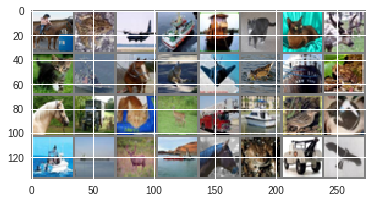

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

## 2. Define a Convolution Neural Network

Needs 3 channels for first layer.



In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3) # channels filters 5x5 filter
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 grid 
        self.conv2 = nn.Conv2d(6, 16, 3) # filters 6 filters at top , 16 filters , grid 5 
        self.conv3= nn.Conv2d(16,18,3)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.1)
        self.fc1 = nn.Linear(18*2*2,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32,10)
        self.fc5 = nn.Linear(10,5)
        self.fc6 = nn.Linear(5,4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1,72)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.dropout2(x)
        x = F.relu(self.fc5(x))
        x=self.fc6(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 18, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.2)
  (dropout2): Dropout(p=0.1)
  (fc1): Linear(in_features=72, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=5, bias=True)
  (fc6): Linear(in_features=5, out_features=4, bias=True)
)

## 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network


This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [13]:
num_epochs = 50

# Used for tracking loss and plotting later
train_losses2 = []
dev_losses2 = []

print('Training...')
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('Epoch', epoch)
    train_loss = 0.0   
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
      
        # Send the inputs to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # track loss for printing
        train_loss += loss.item()
       
    # print average dev loss
    avg_train_loss = train_loss/len(trainloader)
    print('  average train mini-batch loss: {:.6f}'.format(avg_train_loss))
    train_losses2.append(avg_train_loss)

    # Calculate dev loss after every epoch
    with torch.no_grad():
        dev_loss = 0.0
        for data in devloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            dev_loss += loss.item()
        avg_dev_loss = dev_loss/len(devloader)
        print('  average dev mini-batch loss: {:.6f}'.format(avg_dev_loss))
        dev_losses2.append(avg_dev_loss)
            
    # Save the model so we can restore later
    print('  saving model checkpoint')
    # See https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save(net.state_dict(), 'net_checkpoint_{}.pth'.format(epoch))

print('Finished Training')

Training...
Epoch 0


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f86662e0eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil

RuntimeError: ignored

## 5. Test the network on the test data


We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [0]:
# Calculate dev loss after every epoch
with torch.no_grad():
    test_loss = 0.0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = best_net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
    avg_test_loss = test_loss/len(testloader)
    print('  average test mini-batch loss: {:.6f}'.format(avg_test_loss))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(dev_losses, label='Dev loss')
plt.scatter(best_epoch, avg_test_loss, marker='x', color='r', label='Test loss at best_epoch')
plt.legend()
plt.show()